/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/lib/python3.6/site-pack

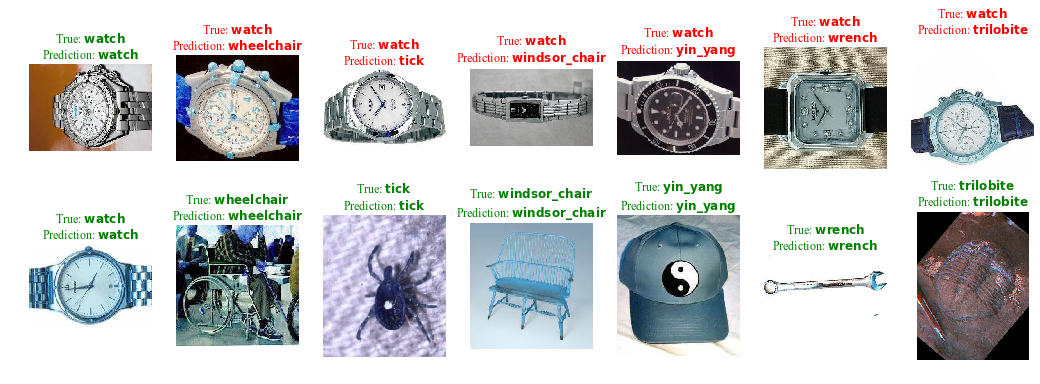

In [14]:
# EXECUTION TIME: 28s

# Python 3 ImportError
import sys
sys.path.append('.')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline


import seaborn as sns
import typing
import time
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import src as ya

random_state = 13

np.random.seed(random_state)

# fetch data
data_train, data_query = ya.data.getCaltech(
    num_descriptors=10000, num_features=128,
    pickle_load=True, random_state=random_state)

# fetch raw images
images = ya.data.getCaltech_images(random_state=0)

# class list in str
class_list = ya.data.getCaltech_classlist(
    'data/Caltech_101/101_ObjectCategories')

X_train, y_train = data_train[:, :-1], data_train[:, -1]
X_test, y_test = data_query[:, :-1], data_query[:, -1]

###########################################################################
# Validation of Hyperparameters
###########################################################################

# Best Parameters
best_params_ = {'n_estimators': 950,
                'max_depth': 10,
                'min_samples_split': 7,
                'min_impurity_decrease': 0.0,
                'max_features': 2
                }

# "optimal" classifier
clf = RandomForestClassifier(**best_params_).fit(X_train, y_train)

# predictions
y_hat = clf.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_hat)


print('Testing Accuracy: %.2f' % clf.score(X_test, y_test))

# most miss-classified class
ij_min = cm.diagonal().argmin()
# most correctly classified class
ij_max = cm.diagonal().argmax()
# get diagonal entries
idx = np.eye(cm.shape[0], dtype=bool)

# logically ignore diagonal elements
cm_mod = np.copy(cm)
np.fill_diagonal(cm_mod, 16)

# miss-classified
idx_min = np.argsort(cm_mod[ij_min])[::-1]



num_samples = 6

# figures
fig, axes = plt.subplots(ncols=num_samples+1, nrows=2,
                         figsize=(3.0 * num_samples, 6.0))
axes = axes.flatten()
# training example
axes[0].imshow(images['train'][15 * ij_min], interpolation='nearest')
axes[0].set_axis_off()
axes[0].set_title(
    'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (class_list[ij_min],
                                                          class_list[ij_min]),
                                                          color='green')
axes[1+num_samples].imshow(images['train'][15 * ij_min + 1],
                           interpolation='nearest')
axes[1+num_samples].set_axis_off()
axes[1+num_samples].set_title(
    'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (class_list[ij_min],
                                                          class_list[ij_min]),
                                                          color='green')



for z in range(num_samples):
    # miss-classified
    wrong_samples = np.where((y_hat == idx_min[z+1]) & (y_test == ij_min))
    axes[z+1].imshow(images['test'][wrong_samples][0], interpolation='nearest')
    _true = class_list[ij_min].replace('_', '\_')
    _pred = class_list[idx_min[z+1]].replace('_', '\_')
    axes[z+1].set_title(
        'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (_true, _pred),
        color='red')
    axes[z+1].set_axis_off()

    # correctly classified
    correct_samples = np.where(
        (y_hat == idx_min[z+1]) & (y_test == idx_min[z+1]))
    axes[z+2+num_samples].imshow(images['test'][correct_samples]
                                 [0], interpolation='nearest')
    axes[z+2+num_samples].set_title(
        'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (_pred, _pred),
        color='green')
    axes[z+2+num_samples].set_axis_off()

fig.savefig('assets/3.2/examples.png', format='png',
            dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.01)
fig.show()